<a href="https://colab.research.google.com/github/psaw/hse-ai24-ml/blob/main/Chocolate_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование рейтинга шоколада.

## Постановка задачи

В датасете содержится информация о более чем 1700 шоколадках. В датасете представлена информация о темном шоколаде.

Система рейтинга шоколада:
5 = Elite
4 = Premium
3 = Satisfactory(3.0) to praiseworthy(3.75)
2 = Disappointing
1 = Unpleasant

Для получения рейтинга каждой шоколадки оцениваются все ее характеристики.

**Задача** - по характеристикам шоколадки научиться предсказывать ее рейтинг без округлений (то есть если рейтинг 3.75 - хорошая модель должна предсказать 3.75).

Рейтинги были собраны Brady Brelinski, Founding Member of the Manhattan Chocolate Society.

## Решение
Автор решения: Юрий Конов, ИИ24
Kaggle: yuryko


## Импорт библиотек, загрузка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

In [2]:
%pip install catboost -q
%pip install association_metrics -q
%pip install category_encoders -q
%pip install optuna -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [4]:
train_df = pd.read_csv(TRAIN)

## Обзор данных, подготовка к обучению

In [5]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


Удаляем все строки с пропусками

In [6]:
train_df.dropna(axis=0, inplace=True)

Выделяем матрицу объект-признак и вектор с целевой переменной

In [7]:
X = train_df # .drop('Rating', axis=1)
y = train_df['Rating']

## Преобразование данных

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1253 non-null   object 
 1   Specific Bean Origin  1253 non-null   object 
 2   REF                   1253 non-null   int64  
 3   Review                1253 non-null   int64  
 4   Cocoa Percent         1253 non-null   object 
 5   Company Location      1253 non-null   object 
 6   Rating                1253 non-null   float64
 7   Bean Type             1253 non-null   object 
 8   Broad Bean Origin     1253 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 97.9+ KB


In [9]:
def cocoa_percent_transformer(X):
    X['Cocoa Percent_numeric'] = X['Cocoa Percent'].str.rstrip('%').astype(float)
    return X


def split_and_replace(X, column_name, separator, replace_value):
    X[column_name+'_cat'] = X[column_name].str.split(separator, expand=True)[0].replace(replace_value, np.nan)
    return X


def clean_df(df):
    _df = cocoa_percent_transformer(df)
    print("1: ", _df.shape)
    _df = split_and_replace(_df, 'Broad Bean Origin', ',', '\xa0')
    print("2: ", _df.shape)
    _df = split_and_replace(_df, 'Specific Bean Origin', ',', '\xa0')
    print("3: ", _df.shape)
    _df = split_and_replace(_df, 'Bean Type', r'[ ,(]', '\xa0')
    print("4: ", _df.shape)
    # Объединение с оригинальными данными, за исключением удаляемых столбцов
    _df = _df.drop(['REF', 'Cocoa Percent', 'Bean Type', 'Broad Bean Origin', 'Specific Bean Origin'], axis=1)
    print("5: ", _df.shape)
    return _df

print("in: ", X.shape)
X_new = clean_df(X.copy())
print("out: ", X_new.shape)
X_new

in:  (1253, 9)
1:  (1253, 10)
2:  (1253, 11)
3:  (1253, 12)
4:  (1253, 13)
5:  (1253, 8)
out:  (1253, 8)


,Company,Review,Company Location,Rating,Cocoa Percent_numeric,Broad Bean Origin_cat,Specific Bean Origin_cat,Bean Type_cat
0,Willie's Cacao,2009,U.K.,3.25,72.0,Venezuela,Rio Caribe,Trinitario
1,Beschle (Felchlin),2010,Switzerland,3.50,72.0,Venezuela,Ocumare,NaN
2,Dark Forest,2015,U.S.A.,3.00,70.0,Tanzania,Tanzania,NaN
3,Brasstown aka It's Chocolate,2013,U.S.A.,3.00,72.0,Dominican Republic,Cooproagro,Trinitario
4,Pralus,2006,France,3.50,75.0,Indonesia,Java,Criollo
...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,2009,U.K.,3.00,80.0,Madagascar,Madagascar,Criollo
1251,Marana,2016,Peru,2.75,70.0,Peru,Cusco,NaN
1252,Arete,2015,U.S.A.,3.50,68.0,Peru,Nacional,Forastero
1253,Fresco,2011,U.S.A.,3.50,72.0,Dominican Republic,Conacado,NaN


#### Биннирование признака `Cocoa Percent_numeric`

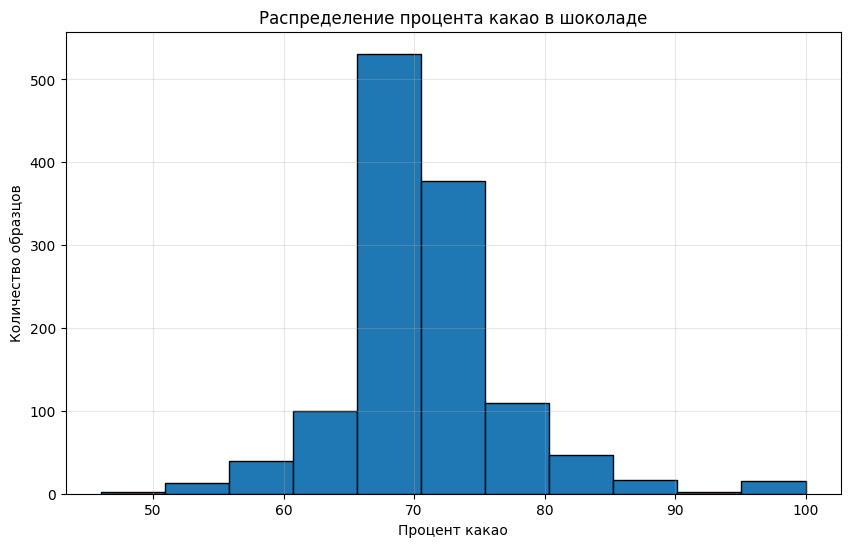

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(X_new['Cocoa Percent_numeric'], bins=11, edgecolor='black')
plt.title('Распределение процента какао в шоколаде')
plt.xlabel('Процент какао')
plt.ylabel('Количество образцов')
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='kmeans', random_state=42)
discretizer.fit(X_new[['Cocoa Percent_numeric']])
X_new['Cocoa Percent_numeric_binned'] = discretizer.transform(X_new[['Cocoa Percent_numeric']])


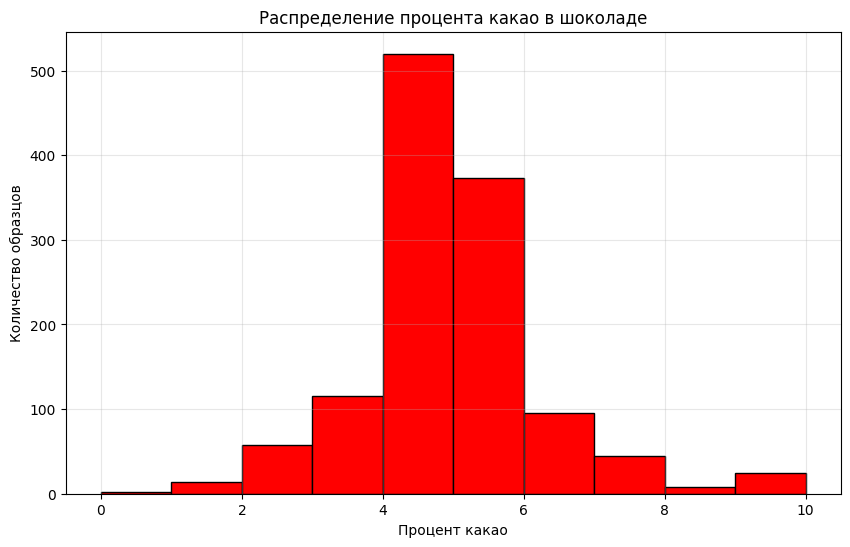

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(X_new['Cocoa Percent_numeric_binned'], color='red', edgecolor='black')
plt.title('Распределение процента какао в шоколаде')
plt.xlabel('Процент какао')
plt.ylabel('Количество образцов')
plt.grid(True, alpha=0.3)
plt.show()


In [13]:
X_new['Cocoa Percent_numeric_binned'].value_counts()

Cocoa Percent_numeric_binned
4.0     520
5.0     373
3.0     115
6.0      95
2.0      57
7.0      44
10.0     15
1.0      14
9.0      10
8.0       8
0.0       2
Name: count, dtype: int64

#### Корреляция признаков

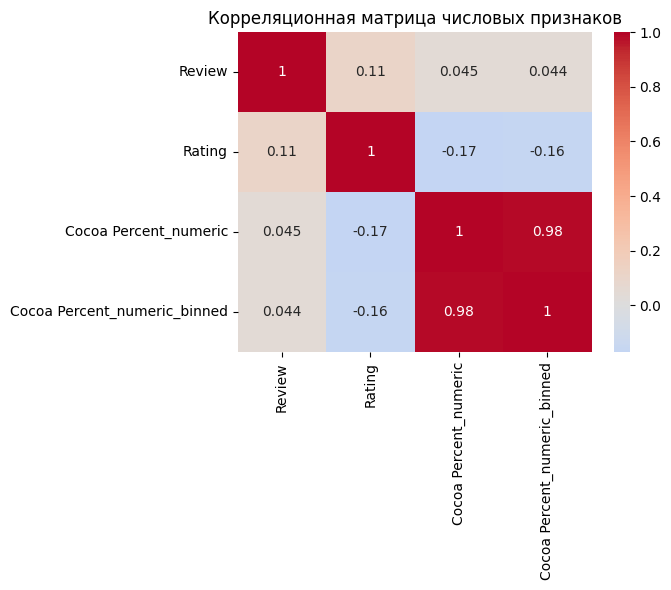

In [14]:
plt.figure(figsize=(7, 6))
correlation_matrix = X_new.select_dtypes(include=['float64', 'int64']).corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()


Ничего интересного.  
Признак `Cocoa Percent_numeric` удалим позже. 

In [15]:
X_new.describe(include='object')

,Company,Company Location,Broad Bean Origin_cat,Specific Bean Origin_cat,Bean Type_cat
count,1253,1253,1198,1253,625
unique,376,58,66,529,9
top,Soma,U.S.A.,Venezuela,Madagascar,Trinitario
freq,34,520,148,46,293


In [16]:
import association_metrics as am
warnings.filterwarnings('ignore')

XC = X_new.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)

cramersv.fit()

,Company,Company Location,Broad Bean Origin_cat,Specific Bean Origin_cat,Bean Type_cat
Company,1.000000,0.999651,0.633931,0.653217,0.816914
Company Location,0.999651,1.000000,0.378944,0.735872,0.268613
Broad Bean Origin_cat,0.633931,0.378944,1.000000,0.976352,0.506266
Specific Bean Origin_cat,0.653217,0.735872,0.976352,1.000000,0.871187
Bean Type_cat,0.816914,0.268613,0.506266,0.871187,1.000000


`Broad Bean Origin_cat` и `Specific Bean Origin_cat` сильно связаны.  
Удалим `Broad Bean Origin_cat`, т.к. в нем есть пропуски

In [17]:
X_new.drop('Broad Bean Origin_cat', axis=1, inplace=True)

#### Визуализируем зависимость целевой переменной от категориальных
(перебрал все категории, ничего не увидел)

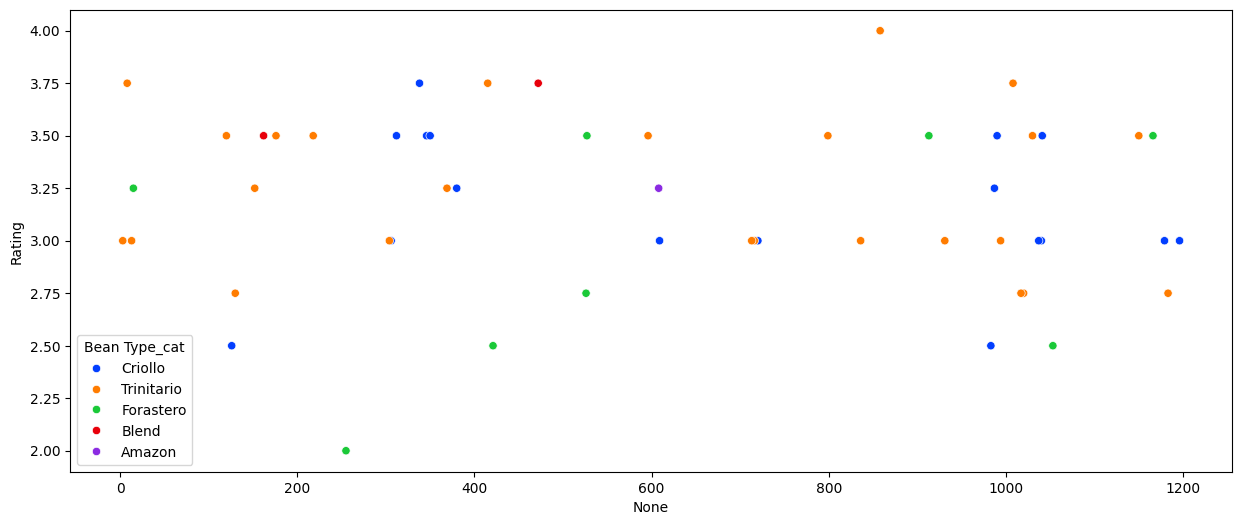

In [18]:
plt.figure(figsize=(15, 6))
XX=X_new.sample(100)
sns.scatterplot(data=XX, x=XX.index, y=y[XX.index], hue='Bean Type_cat', palette='bright');

#### Распределение целевой переменной

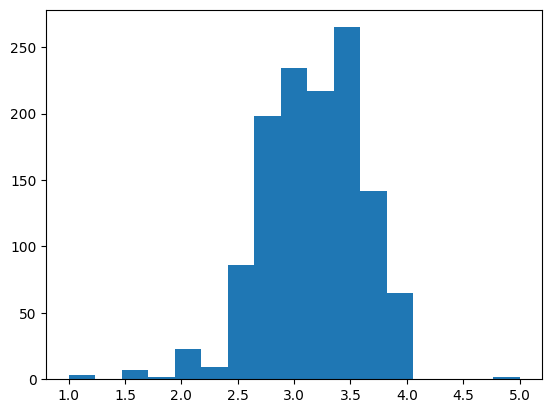

In [19]:
plt.hist(y, bins=17);

Близко к нормальному распределению. Ничего с этим делать не будем.

#### Обработка категориальных признаков

In [20]:
cat_cols = X_new.columns[X_new.dtypes == 'object']
num_cols = X_new.columns[X_new.dtypes != 'object']

Review


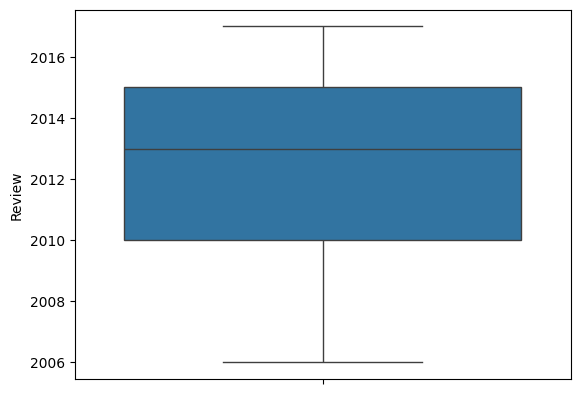

Rating


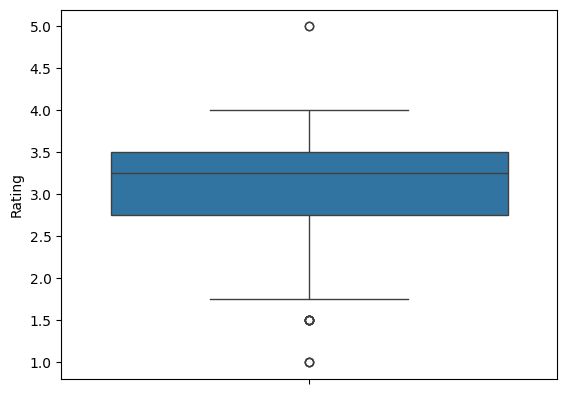

Cocoa Percent_numeric


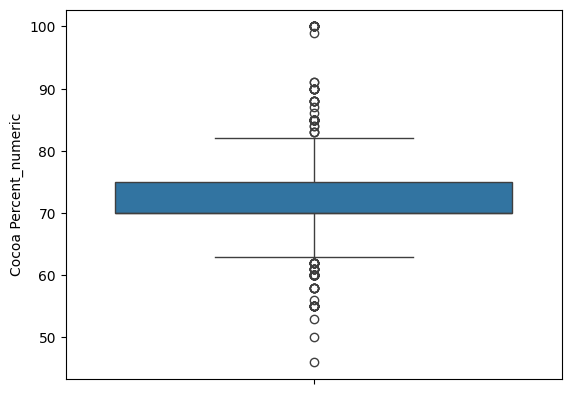

Cocoa Percent_numeric_binned


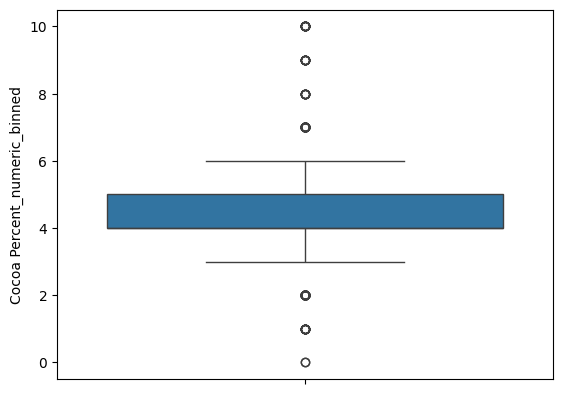

In [21]:
for col in num_cols:
    print(col)
    sns.boxplot(X_new[col])
    plt.show()

Даже экстремальные значения "процент какао" встречаются в жизни, поэтому оставляем как есть.

## Заполнение пропусков

In [22]:
X_new.isna().sum()

Company                           0
Review                            0
Company Location                  0
Rating                            0
Cocoa Percent_numeric             0
Specific Bean Origin_cat          0
Bean Type_cat                   628
Cocoa Percent_numeric_binned      0
dtype: int64

Заполнение пропусков в `Bean Type_cat`:
1. где возможно, заполнять модой по группировке по `Specific Bean Origin_cat`
2. остальное - значением `unknown`

In [23]:
# X_train_transformed['Bean Type_cat'] = X_train_transformed.groupby(['Broad Bean Origin_cat', 'Specific Bean Origin_cat'])['Bean Type_cat'].transform(
#     lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
# )

# X_new['Bean Type_cat'] = X_new.groupby(['Broad Bean Origin_cat'])['Bean Type_cat'].transform(
#     lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
# )

X_new['Bean Type_cat'] = X_new.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_new['Bean Type_cat'] = X_new['Bean Type_cat'].fillna('unknown')

In [24]:
X_new.isna().sum()

Company                         0
Review                          0
Company Location                0
Rating                          0
Cocoa Percent_numeric           0
Specific Bean Origin_cat        0
Bean Type_cat                   0
Cocoa Percent_numeric_binned    0
dtype: int64

## Обучение модели

Устанавливаем катбуст и обучаем его с гиперпараметрами по умолчанию на всех данных

In [25]:
X_new.drop(['Rating', 'Cocoa Percent_numeric'], axis=1, inplace=True)

In [26]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       1253 non-null   object 
 1   Review                        1253 non-null   int64  
 2   Company Location              1253 non-null   object 
 3   Specific Bean Origin_cat      1253 non-null   object 
 4   Bean Type_cat                 1253 non-null   object 
 5   Cocoa Percent_numeric_binned  1253 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 100.8+ KB


Обучаем CatBoostRegressor с гиперпараметрами по умолчанию на всех данных

In [27]:
from catboost import CatBoostRegressor
cat_features = [0, 2, 3, 4]
model = CatBoostRegressor(cat_features=cat_features, verbose=False)

In [227]:
model.fit(X_new, y)

In [228]:
model.score(X_new, y)

0.4932230268399286

In [231]:
print_score(model, X_train, y_train, X_test, y_test)

{'train': 0.49987447657163253, 'test': 0.47297869592858843}

In [30]:
# TODO: что можно сделать для улучшения модели:
# 1. Масштабирование признаков
# 2. Удаление выбросов
# 3. Подбор гиперпараметров

## Предсказание на тестовых данных

### Загрузка тестовых данных

In [31]:
test_df = pd.read_csv(TEST)

In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               540 non-null    object
 1   Specific Bean Origin  540 non-null    object
 2   REF                   540 non-null    int64 
 3   Review                540 non-null    int64 
 4   Cocoa Percent         540 non-null    object
 5   Company Location      540 non-null    object
 6   Bean Type             540 non-null    object
 7   Broad Bean Origin     540 non-null    object
dtypes: int64(2), object(6)
memory usage: 33.9+ KB


### Обработка тестовых данных

In [33]:
X_test_transformed = clean_df(test_df.copy())

1:  (540, 9)
2:  (540, 10)
3:  (540, 11)
4:  (540, 12)
5:  (540, 7)


In [34]:
X_test_transformed['Cocoa Percent_numeric_binned'] = discretizer.transform(X_test_transformed[['Cocoa Percent_numeric']])

In [35]:
X_test_transformed.drop(['Broad Bean Origin_cat', 'Cocoa Percent_numeric'], axis=1, inplace=True)

In [36]:
X_test_transformed.isna().sum()

Company                           0
Review                            0
Company Location                  0
Specific Bean Origin_cat          0
Bean Type_cat                   259
Cocoa Percent_numeric_binned      0
dtype: int64

In [37]:
X_test_transformed['Bean Type_cat'] = X_test_transformed.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_test_transformed['Bean Type_cat'] = X_test_transformed['Bean Type_cat'].fillna('unknown')

In [38]:
X_test_transformed.isna().sum()

Company                         0
Review                          0
Company Location                0
Specific Bean Origin_cat        0
Bean Type_cat                   0
Cocoa Percent_numeric_binned    0
dtype: int64

In [39]:
X_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       540 non-null    object 
 1   Review                        540 non-null    int64  
 2   Company Location              540 non-null    object 
 3   Specific Bean Origin_cat      540 non-null    object 
 4   Bean Type_cat                 540 non-null    object 
 5   Cocoa Percent_numeric_binned  540 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 25.4+ KB


### Предсказание

In [40]:
pred = model.predict(X_test_transformed)

Функция для сохранения предсказания в файл в нужном формате и отправки на Kaggle

In [49]:
def save_and_submit(pred, model, test_df, SUBMISSION_NAME, PREFIX_TXT = "stepik-13.5", submit = False):
    test_df['id'] = np.arange(len(test_df))
    test_df['Rating'] = pred

    test_df[['id','Rating']].to_csv(f"{SUBMISSION_NAME}.csv", index=False)
    with open(f'model-{PREFIX_TXT}-{SUBMISSION_NAME}.pkl', 'wb') as f:
        pickle.dump(model, f)

    if submit:
        !kaggle competitions submit -c chocolate-rating-prediction-ai-edu -f {SUBMISSION_NAME}.csv -m "{SUBMISSION_NAME}"
        !kaggle competitions submissions -c chocolate-rating-prediction-ai-edu

In [52]:
save_and_submit(pred, model, test_df, "submission_4_copy3", submit = True)

100%|██████████████████████████████████████| 11.8k/11.8k [00:01<00:00, 11.3kB/s]
Successfully submitted to Chocolate rating prediction [Ai Edu]fileName                 date                 description         status    publicScore  privateScore  
-----------------------  -------------------  ------------------  --------  -----------  ------------  
submission_4_copy3.csv   2025-02-07 11:36:10  submission_4_copy3  complete  0.22163                    
submission_4_copy2.csv   2025-02-06 13:01:31  submission_4_copy2  complete  0.22163                    
submission_4_copy.csv    2025-02-05 22:41:57  submission_4_copy   complete  0.22207                    
submission_4.csv         2025-02-04 21:44:51                      complete  0.22163                    
submission_3.csv         2025-02-03 22:53:49                      complete  0.16383                    
submission_2.csv         2025-02-02 23:23:33                      complete  0.17017                    
baseline_submission.csv  

## Попытки улучшения

Для начала реализуем пайплайны и проверим их на самой просто линейной регрессии

In [204]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from pprint import pprint as pp
from sklearn.metrics import r2_score

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=42)

In [196]:
r2_scores = {}  # для сохранения r2_scores всех экспериментов

In [275]:
# словарь из двух метрик для печати или вставки куда-то дальшк
def print_score(p, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series):
    res = {}
    res["train"] = p.score(X_train, y_train)
    res["test"] = p.score(X_test, y_test)
    return res


In [436]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType

In [401]:
# Ориентируемся на первую модель.
# Дает 0.22163 на Kaggle

model.score(X_new, y)
r2_scores["model"] = print_score(model, X_train, y_train, X_test, y_test)
pp(r2_scores)

{'best_xgb': {'test': 0.9251419917103052, 'train': 0.2674512430192372},
 'lgb_random': {'test': -0.009032309245039727, 'train': 0.9921626963378684},
 'model': {'test': 0.47297869592858843, 'train': 0.49987447657163253},
 'model_cb': {'test': 0.0927132772872663, 'train': 0.5282661035083401},
 'model_cb2': {'test': 0.11733371423982197, 'train': 0.4500799346346961},
 'model_cb2_2': {'test': 0.11733371423982197, 'train': 0.4500799346346961},
 'model_cb_improved': {'test': 0.031015482570668218,
                       'train': 0.9962683238126473},
 'p1': {'test': -0.013158653940478438, 'train': 0.612098504242313},
 'p10': {'test': -0.019605051636775617, 'train': 0.16969376575796158},
 'p11': {'test': 0.024917267366840967, 'train': 0.9505771133737102},
 'p12': {'test': 0.00030745587896430226, 'train': 0.1635102069979063},
 'p13': {'test': 0.007547606989263267, 'train': 0.9379138544742707},
 'p2': {'test': -0.004615622820015597, 'train': 0.12382269065956364},
 'p3': {'test': -0.026735647384129

### Пайплайны с линейными моделями

In [198]:
from sklearn.preprocessing import MinMaxScaler

p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

# по умолчанию smoothing = 10

p2 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p3 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p4 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p5 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=10)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p6 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p7 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p8 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

In [199]:
for i,p in zip(range(1,9), [p1,p2,p3,p4,p5,p6,p7,p8]):
    p.fit(X_train, y_train)
    pred_ = p.predict(X_test)
    r2_scores[f"p{i}"] = print_score(p, X_train, y_train, X_test, y_test)

pp(r2_scores)

{'model': {'test': 0.47297869592858843, 'train': 0.49987447657163253},
 'p1': {'test': -0.013158653940478438, 'train': 0.612098504242313},
 'p2': {'test': -0.004615622820015597, 'train': 0.12382269065956364},
 'p3': {'test': -0.026735647384129813, 'train': 0.7205170248491082},
 'p4': {'test': -0.004615622820014709, 'train': 0.12382269065956286},
 'p5': {'test': -0.013158653940478215, 'train': 0.6120985042423128},
 'p6': {'test': -0.026735647384129813, 'train': 0.7205170248491082},
 'p7': {'test': 0.06367949166882036, 'train': 0.34331941191550974},
 'p8': {'test': 0.06367949166882092, 'train': 0.34331941191550963}}


Прорыва не случилось. Сменим модель на Случайное дерево.

### Пайплайны случайных деревьев

In [200]:
p9 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p10 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p11 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p12 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p13 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

In [202]:
for i,p in zip(range(9,14), [p9,p10,p11,p12,p13]):
    p.fit(X_train, y_train)
    pred_ = p.predict(X_test)
    r2_scores[f"p{i}"] = print_score(p, X_train, y_train, X_test, y_test)

pp(r2_scores)

{'model': {'test': 0.47297869592858843, 'train': 0.49987447657163253},
 'p1': {'test': -0.013158653940478438, 'train': 0.612098504242313},
 'p10': {'test': -0.019605051636775617, 'train': 0.16969376575796158},
 'p11': {'test': 0.024917267366840967, 'train': 0.9505771133737102},
 'p12': {'test': 0.00030745587896430226, 'train': 0.1635102069979063},
 'p13': {'test': 0.007547606989263267, 'train': 0.9379138544742707},
 'p2': {'test': -0.004615622820015597, 'train': 0.12382269065956364},
 'p3': {'test': -0.026735647384129813, 'train': 0.7205170248491082},
 'p4': {'test': -0.004615622820014709, 'train': 0.12382269065956286},
 'p5': {'test': -0.013158653940478215, 'train': 0.6120985042423128},
 'p6': {'test': -0.026735647384129813, 'train': 0.7205170248491082},
 'p7': {'test': 0.06367949166882036, 'train': 0.34331941191550974},
 'p8': {'test': 0.06367949166882092, 'train': 0.34331941191550963},
 'p9': {'test': 0.005232846420800907, 'train': 0.9507038739153184}}


Плохо. 

## Подбор гиперпараметров

Выделим пайплайн для предобработки данных, чтобы не запускать его каждый раз при подборе гиперпараметров.

In [320]:
data_pipeline = Pipeline([
        ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
        ('scaler_', MinMaxScaler())
]).set_output(transform='pandas')

X_train_good = data_pipeline.fit_transform(X_train, y_train)
X_test_good = data_pipeline.transform(X_test)
X_new_good = data_pipeline.transform(X_new)
X_test_transformed_good = data_pipeline.transform(X_test_transformed)


### Random Forest

In [514]:
import optuna

def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_features": trial.suggest_float("max_features", 0.1, 1.),
        "max_depth": trial.suggest_int("max_depth", 2, 16),
    }

    estimator = RandomForestRegressor(**param, verbose=False, n_jobs=-1, random_state=42)

    estimator.fit(X_train_good, y_train)
    _pred = estimator.predict(X_test_good)

    return  r2_score(y_test, _pred)

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective, n_trials=50)
print(study_rf.best_trial)

[I 2025-02-08 18:49:58,121] A new study created in memory with name: no-name-d1f44131-6601-48e6-9411-beb714f2ec1a
[I 2025-02-08 18:49:58,621] Trial 0 finished with value: -0.008585099628190651 and parameters: {'n_estimators': 489, 'max_features': 0.33876882004991465, 'max_depth': 7}. Best is trial 0 with value: -0.008585099628190651.
[I 2025-02-08 18:49:58,759] Trial 1 finished with value: -0.042865922775760845 and parameters: {'n_estimators': 175, 'max_features': 0.7740509890960973, 'max_depth': 3}. Best is trial 0 with value: -0.008585099628190651.
[I 2025-02-08 18:49:59,095] Trial 2 finished with value: -0.019637163075594932 and parameters: {'n_estimators': 445, 'max_features': 0.6082011193624725, 'max_depth': 6}. Best is trial 0 with value: -0.008585099628190651.
[I 2025-02-08 18:49:59,589] Trial 3 finished with value: -0.0132518308169145 and parameters: {'n_estimators': 635, 'max_features': 0.4472853780923738, 'max_depth': 6}. Best is trial 0 with value: -0.008585099628190651.
[I 

FrozenTrial(number=30, state=1, values=[0.025677752648015195], datetime_start=datetime.datetime(2025, 2, 8, 18, 50, 10, 350493), datetime_complete=datetime.datetime(2025, 2, 8, 18, 50, 10, 527525), params={'n_estimators': 223, 'max_features': 0.5080549483549279, 'max_depth': 11}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'max_depth': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=30, value=None)


In [518]:
model_rf_best = RandomForestRegressor(**study_rf.best_trial.params, verbose=False, n_jobs=-1, random_state=42)

model_rf_best.fit(X_new_good, y)
r2_scores[f"model_rf_best"] = print_score(model_rf_best, X_train_good, y_train, X_test_good, y_test)
pp(r2_scores[f"model_rf_best"])

{'test': 0.6127046891416561, 'train': 0.24759048925230542}


Плохой результат. Не будем его загружать на Kaggle.

### CatBoost

In [516]:
import optuna

def objective_cb(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 16),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
    }

    estimator = CatBoostRegressor(**param, cat_features=cat_features, verbose=False)

    estimator.fit(X_train, y_train)
    _pred = estimator.predict(X_test)

    return r2_score(y_test, _pred)

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_cb, n_trials=50)
print(study_cb.best_trial)

[I 2025-02-08 18:50:22,543] A new study created in memory with name: no-name-ae8465d8-d9a4-4359-8fef-4119b661ae04
[I 2025-02-08 18:50:23,520] Trial 0 finished with value: 0.10883667863686519 and parameters: {'n_estimators': 111, 'max_depth': 15, 'learning_rate': 0.044467058587989924}. Best is trial 0 with value: 0.10883667863686519.
[I 2025-02-08 18:50:29,880] Trial 1 finished with value: 0.08648162279962957 and parameters: {'n_estimators': 377, 'max_depth': 14, 'learning_rate': 0.043559645173612487}. Best is trial 0 with value: 0.10883667863686519.
[I 2025-02-08 18:50:30,394] Trial 2 finished with value: 0.07468029120456032 and parameters: {'n_estimators': 228, 'max_depth': 10, 'learning_rate': 0.06367243698563002}. Best is trial 0 with value: 0.10883667863686519.
[I 2025-02-08 18:50:30,883] Trial 3 finished with value: 0.11723803051499349 and parameters: {'n_estimators': 224, 'max_depth': 9, 'learning_rate': 0.024220186153841625}. Best is trial 3 with value: 0.11723803051499349.
[I 2

FrozenTrial(number=49, state=1, values=[0.12295776988013696], datetime_start=datetime.datetime(2025, 2, 8, 18, 52, 1, 67157), datetime_complete=datetime.datetime(2025, 2, 8, 18, 52, 1, 258868), params={'n_estimators': 353, 'max_depth': 3, 'learning_rate': 0.027950521810936702}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_depth': IntDistribution(high=16, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None)}, trial_id=49, value=None)


In [517]:
model_cb_best = CatBoostRegressor(**study_cb.best_trial.params, cat_features=cat_features, verbose=False)

model_cb_best.fit(X_new, y)
r2_scores["model_cb_best"] = print_score(model_cb_best, X_train, y_train, X_test, y_test)
pp(r2_scores["model_cb_best"])


{'test': 0.35506150380036217, 'train': 0.42238368990126207}


Скромный результат. Но и его загрузим на Kaggle.

In [456]:
pred = model_cb_best.predict(X_test_transformed)
save_and_submit(pred, model_cb_best, test_df, "submission_cb_best", submit = True)

98278.27s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


100%|██████████████████████████████████████| 11.8k/11.8k [00:00<00:00, 15.6kB/s]
Successfully submitted to Chocolate rating prediction [Ai Edu]

98286.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


fileName                         date                 description                  status    publicScore  privateScore  
-------------------------------  -------------------  ---------------------------  --------  -----------  ------------  
submission_cb_best.csv           2025-02-08 14:37:39  submission_cb_best           complete  0.16985                    
submission_cb_cat.csv            2025-02-08 13:56:20  submission_cb_cat            complete  0.21739                    
submission_lgb_best.csv          2025-02-07 22:56:58  submission_lgb_best          complete  0.05762                    
submission_cb_improved_good.csv  2025-02-07 22:52:36  submission_cb_improved_good  complete  0.02251                    
submission_cb_improved.csv       2025-02-07 22:33:30  submission_cb_improved       complete  0.17161                    
submission_4_copy_half.csv       2025-02-07 21:57:52  submission_4_copy_half       complete  0.13458                    
submission_4_copy_q.csv         

### LightGBM

In [468]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
warnings.filterwarnings('ignore')

def objective(trial):
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_jobs': -1,
        'num_leaves': trial.suggest_int('num_leaves', 31, 127),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9)
    }
    
    _model = lgb.LGBMRegressor(**lgb_params)
       
    scores = cross_val_score(_model, X_new_good, y, cv=5, scoring='r2')
    return scores.mean()

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective, n_trials=20)

lgb_model = lgb.LGBMRegressor(**study_lgbm.best_params)


[I 2025-02-08 18:10:25,413] A new study created in memory with name: no-name-a686d3e0-a358-48d0-b288-831852b27b4d
[I 2025-02-08 18:10:37,690] Trial 0 finished with value: 0.218944719525819 and parameters: {'num_leaves': 53, 'max_depth': 6, 'learning_rate': 0.03301416621529571, 'n_estimators': 1370, 'min_child_samples': 28, 'subsample': 0.7316711372116471, 'colsample_bytree': 0.7953319563330108}. Best is trial 0 with value: 0.218944719525819.
[I 2025-02-08 18:11:04,916] Trial 1 finished with value: 0.2538905799072512 and parameters: {'num_leaves': 40, 'max_depth': 11, 'learning_rate': 0.012036943096045976, 'n_estimators': 1089, 'min_child_samples': 11, 'subsample': 0.7812366386656331, 'colsample_bytree': 0.7212638350750366}. Best is trial 1 with value: 0.2538905799072512.
[I 2025-02-08 18:11:35,790] Trial 2 finished with value: 0.20335465604755698 and parameters: {'num_leaves': 116, 'max_depth': 9, 'learning_rate': 0.01771557962537751, 'n_estimators': 1402, 'min_child_samples': 9, 'subs

In [469]:
lgb_model.fit(X_new_good, y)
r2_scores["model_lgbm_best"] = print_score(lgb_model, X_train_good, y_train, X_test_good, y_test)
pp(r2_scores["model_lgbm_best"])

{'test': 0.5942050386170745, 'train': 0.2506873862303991}


In [470]:
pred = lgb_model.predict(X_test_transformed_good)
save_and_submit(pred, lgb_model, test_df, "submission_lgb_best", submit = True)

100799.05s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


100%|██████████████████████████████████████| 11.8k/11.8k [00:00<00:00, 15.1kB/s]
Successfully submitted to Chocolate rating prediction [Ai Edu]

100807.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


fileName                         date                 description                  status    publicScore  privateScore  
-------------------------------  -------------------  ---------------------------  --------  -----------  ------------  
submission_lgb_best.csv          2025-02-08 15:19:39  submission_lgb_best          complete  0.06066                    
submission_stacking2.csv         2025-02-08 14:51:12  submission_stacking2         complete  0.09333                    
submission_cb_best.csv           2025-02-08 14:37:39  submission_cb_best           complete  0.16985                    
submission_cb_cat.csv            2025-02-08 13:56:20  submission_cb_cat            complete  0.21739                    
submission_lgb_best.csv          2025-02-07 22:56:58  submission_lgb_best          complete  0.05762                    
submission_cb_improved_good.csv  2025-02-07 22:52:36  submission_cb_improved_good  complete  0.02251                    
submission_cb_improved.csv      

### XGBoost

In [506]:
import optuna
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
from xgboost import XGBRegressor

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
    }

    # Реализуем K-fold кросс-валидацию, т.к. 
    # XGBoost конфликтует с cross_val_score (и даже sklearn==1.6.1)
    # https://github.com/scikit-learn/scikit-learn/pull/30516
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in kf.split(X_new_good):
        X_fold_train = X_new_good.iloc[train_idx]
        y_fold_train = y.iloc[train_idx]
        X_fold_val = X_new_good.iloc[val_idx]
        y_fold_val = y.iloc[val_idx]
        
        # Преобразуем данные в формат DMatrix
        dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
        dval = xgb.DMatrix(X_fold_val, label=y_fold_val)
        
        # Обучаем модель
        num_round = trial.suggest_int('num_round', 1000, 3000)
        model = xgb.train(
            params,
            dtrain,
            num_round,
            evals=[(dval, 'eval')],
            early_stopping_rounds=100,
            verbose_eval=False
        )
        
        # Делаем предсказания и считаем R2
        preds = model.predict(dval)
        fold_score = r2_score(y_fold_val, preds)
        scores.append(fold_score)
    
    # _model = XGBRegressor(**params)
    # _pipeline = make_pipeline(_model)
    # scores = cross_val_score(_model, X_new_good, y, cv=5, scoring='r2')


    # Возвращаем среднее значение R2 по всем фолдам
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_xgb = xgb.XGBRegressor(**study.best_params, random_state=42)

[I 2025-02-08 18:45:03,209] A new study created in memory with name: no-name-e047daaf-0c15-448a-95e8-57740a16ed53
[I 2025-02-08 18:45:05,816] Trial 0 finished with value: 0.31665535777858944 and parameters: {'max_depth': 6, 'learning_rate': 0.03721472596044198, 'n_estimators': 1054, 'min_child_weight': 4, 'subsample': 0.8322980611091904, 'colsample_bytree': 0.8375384075775949, 'gamma': 0.7424003325579952, 'reg_alpha': 0.7210355781995549, 'reg_lambda': 0.9141829170413683, 'num_round': 2650}. Best is trial 0 with value: 0.31665535777858944.
[I 2025-02-08 18:45:06,652] Trial 1 finished with value: 0.3133579016540311 and parameters: {'max_depth': 12, 'learning_rate': 0.08590294629442706, 'n_estimators': 1083, 'min_child_weight': 6, 'subsample': 0.9662098860494835, 'colsample_bytree': 0.9646772716755894, 'gamma': 0.7165153998553417, 'reg_alpha': 0.18652454048240075, 'reg_lambda': 0.32489601849455996, 'num_round': 2969}. Best is trial 0 with value: 0.31665535777858944.
[I 2025-02-08 18:45:11

In [507]:
best_xgb.fit(X_new_good, y)
r2_scores["best_xgb"] = print_score(best_xgb, X_train_good, y_train, X_test_good, y_test)
pp(r2_scores["best_xgb"])

{'test': 0.2880129492045922, 'train': 0.19491236186210326}


## Стекинг

In [521]:
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline

estimators = [
    ('cb_best', model_cb_best),
    ('cb', model),
    ('rf_best', make_pipeline(data_pipeline, model_rf_best)),
    ('lgbm_best', make_pipeline(data_pipeline, lgb_model)),
    # ('xgb_best', make_pipeline(data_pipeline, best_xgb)),
    ]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10, random_state=42))

In [522]:
stacking_model.fit(X_new, y)
r2_scores["pred_stacking"] = print_score(stacking_model, X_train, y_train, X_test, y_test)
pp(r2_scores["pred_stacking"])

{'test': 0.32385150406033913, 'train': 0.35593806420778895}


In [476]:
pred = stacking_model.predict(X_test_transformed)
save_and_submit(pred, stacking_model, test_df, "submission_stacking3", submit = True)

101160.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


100%|██████████████████████████████████████| 4.82k/4.82k [00:00<00:00, 5.92kB/s]
Successfully submitted to Chocolate rating prediction [Ai Edu]

101168.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


fileName                         date                 description                  status    publicScore  privateScore  
-------------------------------  -------------------  ---------------------------  --------  -----------  ------------  
submission_stacking3.csv         2025-02-08 15:25:41  submission_stacking3         complete  0.05148                    
submission_stacking3.csv         2025-02-08 15:24:21  submission_stacking3         complete  0.12401                    
submission_lgb_best.csv          2025-02-08 15:19:39  submission_lgb_best          complete  0.06066                    
submission_stacking2.csv         2025-02-08 14:51:12  submission_stacking2         complete  0.09333                    
submission_cb_best.csv           2025-02-08 14:37:39  submission_cb_best           complete  0.16985                    
submission_cb_cat.csv            2025-02-08 13:56:20  submission_cb_cat            complete  0.21739                    
submission_lgb_best.csv         

# Результаты

Самый лучший результат на Kaggle 0.22163 показан моделью CatBoostRegressor с параметрами по умолчанию.  
Все попытки улучшить результат при помощи оптимизации гиперпараметров или других моделей оказались неудачными.

In [523]:
!kaggle competitions submissions -c chocolate-rating-prediction-ai-edu

103738.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


fileName                         date                 description                  status    publicScore  privateScore  
-------------------------------  -------------------  ---------------------------  --------  -----------  ------------  
submission_stacking3.csv         2025-02-08 15:25:41  submission_stacking3         complete  0.05148                    
submission_stacking3.csv         2025-02-08 15:24:21  submission_stacking3         complete  0.12401                    
submission_lgb_best.csv          2025-02-08 15:19:39  submission_lgb_best          complete  0.06066                    
submission_stacking2.csv         2025-02-08 14:51:12  submission_stacking2         complete  0.09333                    
submission_cb_best.csv           2025-02-08 14:37:39  submission_cb_best           complete  0.16985                    
submission_cb_cat.csv            2025-02-08 13:56:20  submission_cb_cat            complete  0.21739                    
submission_lgb_best.csv         